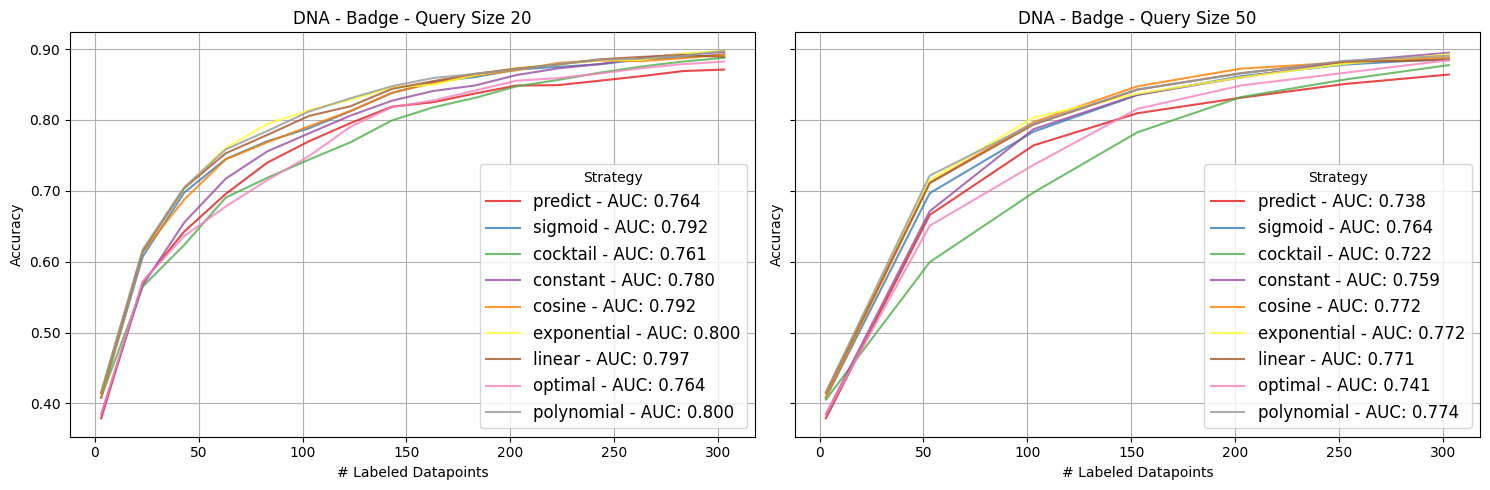

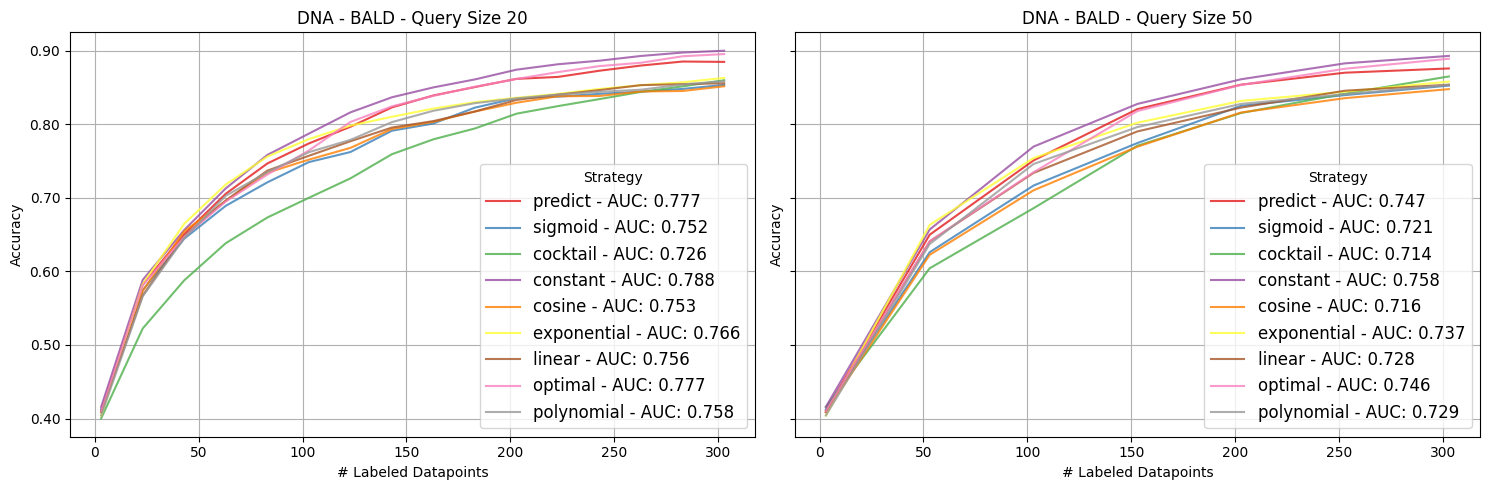

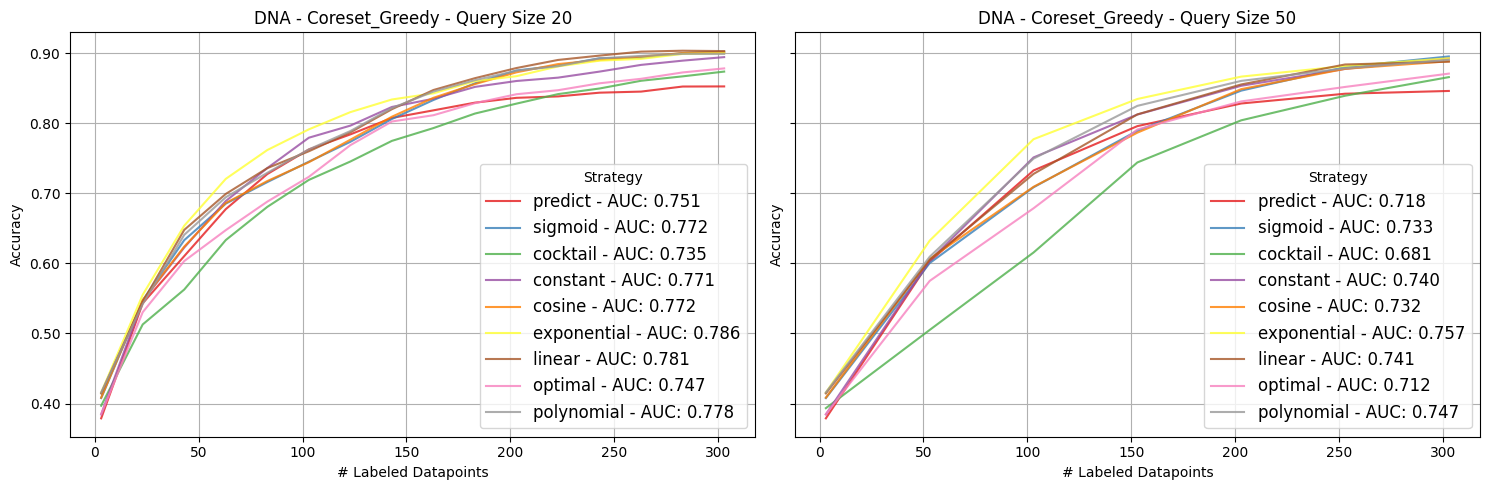

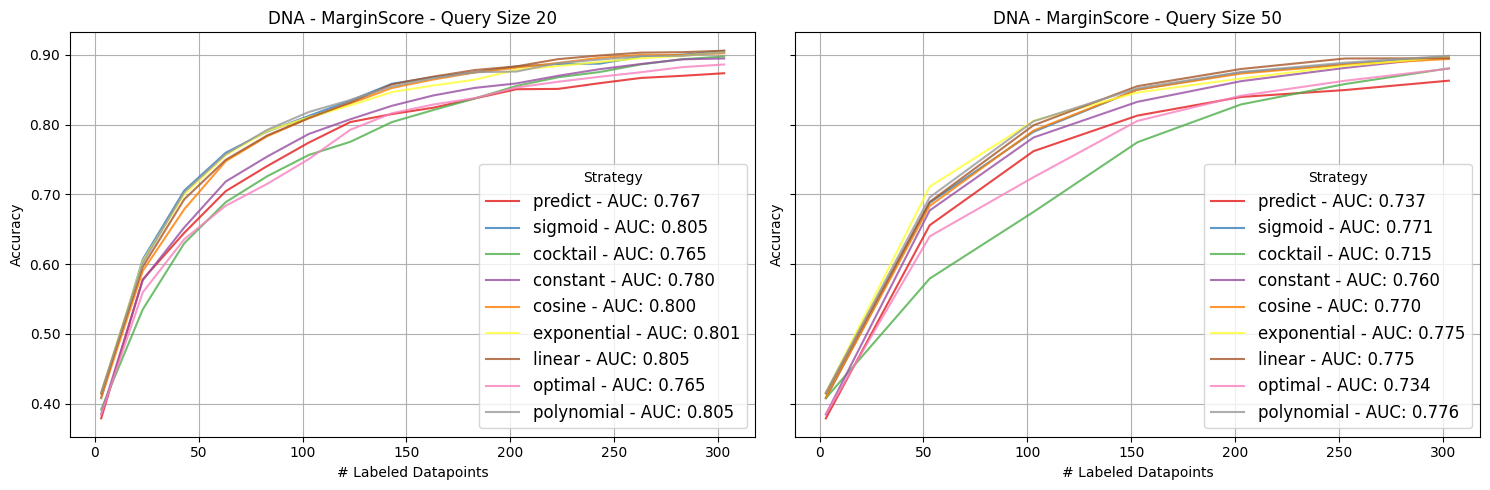

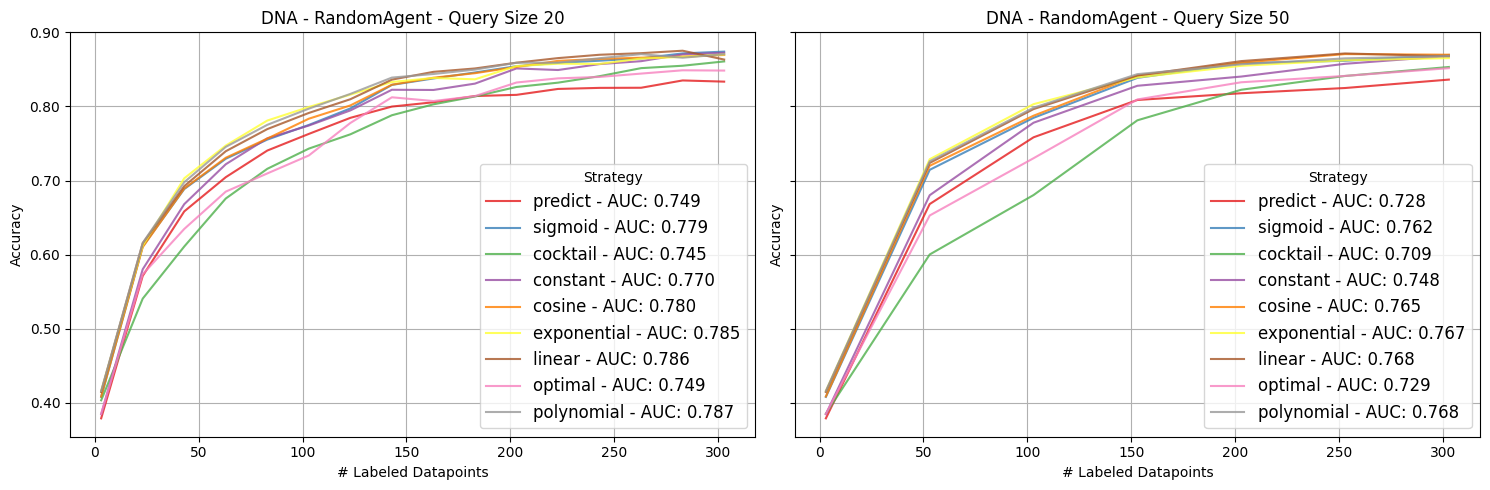

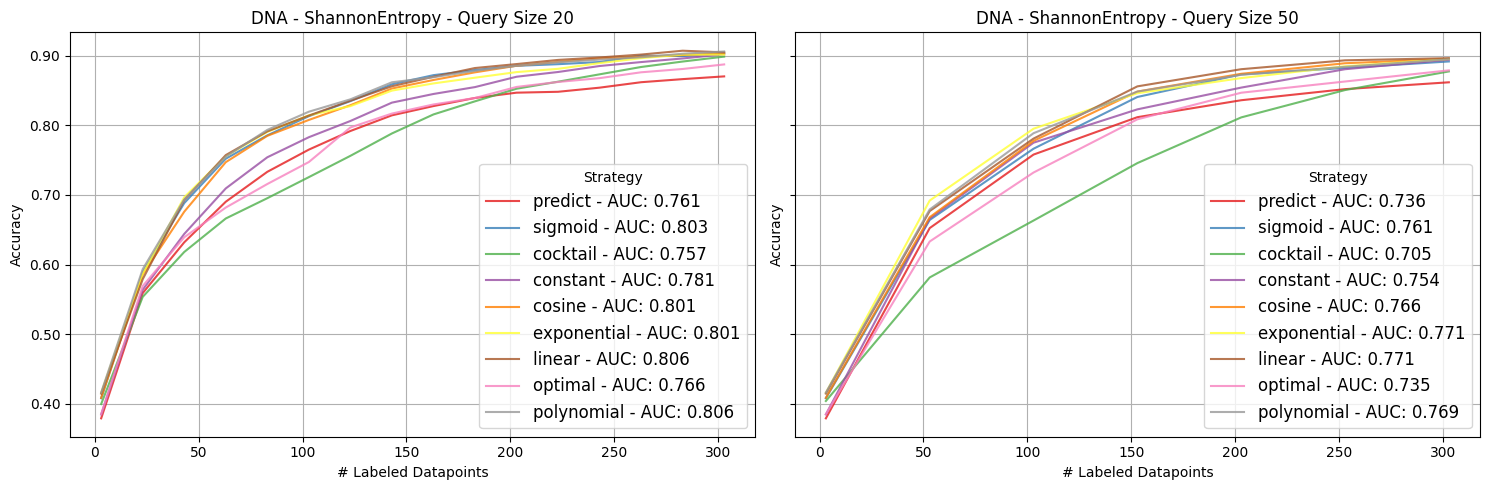

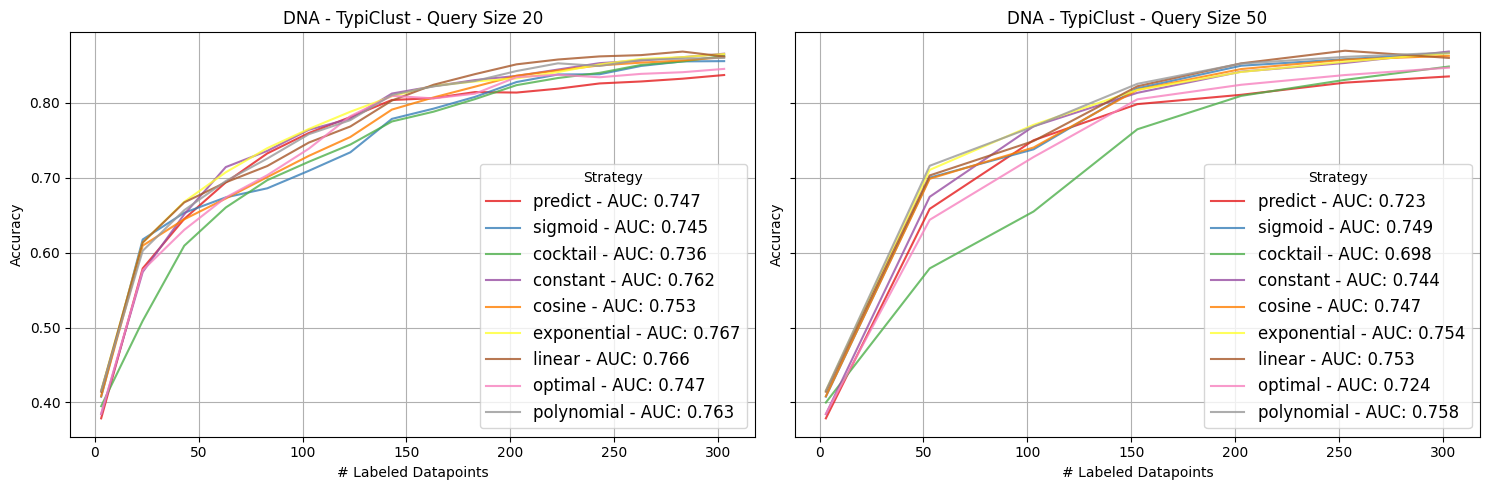

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from core.helper_functions import _load_eval_data, plot_batch_benchmark

def plot_agent_strategies(dataset, query_sizes, agent, strategies, base_path):
    # Set up the plot with two subplots for each query size
    fig, axs = plt.subplots(1, len(query_sizes), figsize=(15, 5), sharey=True)
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(strategies)))
    
    for i, query_size in enumerate(query_sizes):
        ax = axs[i]
        for color, strategy in zip(colors, strategies):
            # Define path and load data
            try:
                x, y, _ = _load_eval_data(dataset, query_size, f"{agent}_{strategy}")
                # Plot each strategy
                plot_batch_benchmark(ax, x, y, color, strategy)
            except FileNotFoundError:
                print(f"Data not found for {dataset}, {agent}, {query_size}, {strategy}")
                continue
        
        ax.set_title(f"{dataset} - {agent} - Query Size {query_size}")
        ax.set_xlabel("# Labeled Datapoints")
        ax.set_ylabel("Accuracy")
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
        ax.grid(visible=True)
        ax.legend(title="Strategy", loc='best', fontsize= 'large')
    
    plt.tight_layout()
    plt.show()

# Parameters
base_path = "D:/School/Hildesheim/Thesis/Code-Base/Results/Experiments"
datasets = ["DNA"]  # Modify as needed
query_sizes = [20, 50]
agents = ["Badge", "BALD", "Coreset_Greedy", "MarginScore", "RandomAgent", "ShannonEntropy", "TypiClust"]
strategies = ["predict", "sigmoid", "cocktail", "constant", "cosine", "exponential", "linear", "optimal", "polynomial"]

# Loop through datasets and agents to create plots
for dataset in datasets:
    for agent in agents:
        plot_agent_strategies(dataset, query_sizes, agent, strategies, base_path)

In [2]:
import os
import numpy as np
import pandas as pd
from core.helper_functions import _load_eval_data

def calculate_auc_dataframe(datasets, query_sizes, agents, strategies, base_path):
    # Initialize a dictionary to store AUC results
    auc_data = {
        "Dataset": [],
        "Query Size": [],
        "Agent": [],
        "Strategy": [],
        "AUC": []
    }

    # Loop through all parameters to calculate AUC
    for dataset in datasets:
        for query_size in query_sizes:
            for agent in agents:
                for strategy in strategies:
                    try:
                        x, y, _ = _load_eval_data(dataset, query_size, f"{agent}_{strategy}")
                        auc_value = np.trapz(y, x) / max(x)  # Calculate normalized AUC
                        # Append results to dictionary
                        auc_data["Dataset"].append(dataset)
                        auc_data["Query Size"].append(query_size)
                        auc_data["Agent"].append(agent)
                        auc_data["Strategy"].append(strategy)
                        auc_data["AUC"].append(auc_value)
                    except FileNotFoundError:
                        print(f"Data not found for {dataset}, {agent}, {query_size}, {strategy}")
                        auc_data["Dataset"].append(dataset)
                        auc_data["Query Size"].append(query_size)
                        auc_data["Agent"].append(agent)
                        auc_data["Strategy"].append(strategy)
                        auc_data["AUC"].append(np.nan)
    
    # Convert dictionary to DataFrame
    auc_df = pd.DataFrame(auc_data)
    return auc_df

# Parameters
base_path = "D:/School/Hildesheim/Thesis/Code-Base/Results/Experiments"
datasets = ["DNA"]  # Modify as needed
query_sizes = [20, 50]
agents = ["Badge", "BALD", "Coreset_Greedy", "MarginScore", "RandomAgent", "ShannonEntropy", "TypiClust"]
strategies = ["predict", "sigmoid", "cocktail", "constant", "cosine", "exponential", "linear", "optimal", "polynomial"]

# Generate the AUC DataFrame
auc_results_df = calculate_auc_dataframe(datasets, query_sizes, agents, strategies, base_path)
auc_results_df

# Optionally, save to CSV
#auc_results_df.to_csv("results&plots/AUC_results.csv", index=False)
#print("AUC results saved to results&plots/AUC_results.csv")

,Dataset,Query Size,Agent,Strategy,AUC
0,DNA,20,Badge,predict,0.765945
1,DNA,20,Badge,sigmoid,0.793505
2,DNA,20,Badge,cocktail,0.761374
3,DNA,20,Badge,constant,0.781166
4,DNA,20,Badge,cosine,0.793815
...,...,...,...,...,...
121,DNA,50,TypiClust,cosine,0.758254
122,DNA,50,TypiClust,exponential,0.764988
123,DNA,50,TypiClust,linear,0.764683
124,DNA,50,TypiClust,optimal,0.734911


In [3]:
auc_results_df['Rank Within Agent/Query'] = auc_results_df.groupby(['Dataset', 'Query Size', 'Agent'])['AUC'].rank(ascending=False, method='average')

# Average rank for each Strategy across all Agents for each Query Size and Dataset combination
strategy_avg_rank_df = auc_results_df.groupby(['Dataset', 'Query Size', 'Strategy'])['Rank Within Agent/Query'].mean().reset_index()
strategy_avg_rank_df.rename(columns={'Rank Within Agent/Query': 'Average Rank Across Agents'}, inplace=True)

# Overall average rank for each Strategy across all Datasets, Query Sizes, and Agents
overall_avg_rank_df = auc_results_df.groupby('Strategy')['Rank Within Agent/Query'].mean().reset_index()
overall_avg_rank_df.rename(columns={'Rank Within Agent/Query': 'Overall Average Rank'}, inplace=True)

# Sort the DataFrames to show the rankings clearly
strategy_avg_rank_df = strategy_avg_rank_df.sort_values(by=['Dataset', 'Query Size', 'Average Rank Across Agents'])
overall_avg_rank_df = overall_avg_rank_df.sort_values(by='Overall Average Rank')

# Display results
print("Rankings for each strategy, dataset, and query size across agents:")
print(strategy_avg_rank_df)
print("\nOverall rankings for each strategy across all datasets, query sizes, and agents:")
print(overall_avg_rank_df)

# Optionally, save the results to CSV files for further analysis or documentation
results_folder = "results&plots"
strategy_avg_rank_df.to_csv(os.path.join(results_folder, "Strategy_Avg_Rank_By_Agent_Query.csv"), index=False)
overall_avg_rank_df.to_csv(os.path.join(results_folder, "Overall_Strategy_Avg_Rank.csv"), index=False)

Rankings for each strategy, dataset, and query size across agents:
   Dataset  Query Size     Strategy  Average Rank Across Agents
6      DNA          20   polynomial                    2.285714
3      DNA          20  exponential                    2.714286
4      DNA          20       linear                    2.857143
8      DNA          20      sigmoid                    4.857143
1      DNA          20     constant                    5.000000
2      DNA          20       cosine                    5.000000
7      DNA          20      predict                    6.285714
5      DNA          20      optimal                    7.142857
0      DNA          20     cocktail                    8.857143
15     DNA          50   polynomial                    2.142857
12     DNA          50  exponential                    2.571429
13     DNA          50       linear                    3.000000
11     DNA          50       cosine                    4.714286
10     DNA          50     constant  